In [1]:
import logging
import os
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch 
# from torch import diff
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import monai
from monai.transforms import AsChannelFirst, AsDiscrete, Compose, LoadImage, ToTensor, RandAxisFlip, Randomizable, RandFlip, Transform
import torch.optim as optim
import time
from torch_lr_finder import LRFinder
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import balanced_accuracy_score
from IPython.display import clear_output
import pandas as pd
import nibabel as nib
from typing import Tuple, Callable
from torch.nn.modules.batchnorm import _BatchNorm 

In [2]:
sub_det_df = pd.read_excel('/data-braingut/bharath/Histogran_finctional_connectivity_ML/data/rs_fmri_sub_details_all.xlsx')
cur_sub_list_before = sub_det_df['Subject_ID_before'].to_numpy()
cur_sub_list_after = sub_det_df['Subject_ID_after'].to_numpy()
age = sub_det_df['age'].to_numpy()
sex = sub_det_df['sex'].to_numpy()
sub_labels = sub_det_df['sub_labels'].to_numpy()
labels = sub_det_df['labels'].to_numpy()
mean_motion_before = sub_det_df['mean_motion_before'].to_numpy()
mean_motion_after = sub_det_df['mean_motion_after'].to_numpy()
print(len(cur_sub_list_after))

89


In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)
for train_idx,test_idx in sss.split(np.zeros(len(labels)),labels):
    train_sub = cur_sub_list_after[train_idx]
    train_y = labels[train_idx]
    test_sub = cur_sub_list_after[test_idx]
    test_y = labels[test_idx]
print(len(train_sub),len(train_y),len(test_sub),len(test_y)) 

75 75 14 14


In [4]:
device= torch.device('cuda:1')

In [5]:
all_data_train = np.zeros((len(train_sub),196,22,30,18), dtype = 'float32')
for i in range(len(train_sub)):
    train_file_name = '/data-braingut/bharath/rs_fmri_deep_learning_data/LH_insula/%s.nii.gz'%train_sub[i]
    brik1 = nib.load(train_file_name)
    all_data_train[i,:] = np.moveaxis(brik1.get_fdata(),3,0).astype('float32')
        
all_data_test = np.zeros((len(test_sub),196,22,30,18), dtype = 'float32')        
for i in range(len(test_sub)):
    test_file_name = '/data-braingut/bharath/rs_fmri_deep_learning_data/LH_insula/%s.nii.gz'%test_sub[i]
    brik1 = nib.load(test_file_name)
    all_data_test[i,:] = np.moveaxis(brik1.get_fdata(),3,0).astype('float32')
#     print(i, all_data[i].dtype)

all_data_train = torch.from_numpy(all_data_train).to(device)
all_data_test = torch.from_numpy(all_data_test).to(device)

# all_data_train = torch.from_numpy(all_data_train)
# all_data_test = torch.from_numpy(all_data_test)

train_y_gpu =  torch.from_numpy(train_y).to(device)
# train_y_gpu = train_y_gpu.float()
test_y_gpu =  torch.from_numpy(test_y).to(device)
# test_y_gpu = test_y_gpu.float()

In [6]:
# class taken from 
class Pool4d(nn.Module):
    def __init__(self,
                 kernel_size: Tuple[int, int, int, int],
                 stride: Tuple[int, int, int, int],
                 padding: Tuple[int, int, int, int],
                 max_avg = 'avg'):

        super(Pool4d, self).__init__()

        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.max_avg = max_avg
        if(max_avg == 'avg'):
            self.pool3d_layer = torch.nn.AvgPool3d(kernel_size = kernel_size[1:], stride=stride[1:], padding = 0)
        else:
            self.pool3d_layer = torch.nn.MaxPool3d(kernel_size = kernel_size[1:], stride=stride[1:], padding = 0)

    def forward(self, X):
        if(self.max_avg == 'avg'):
            X = F.pad(X, (self.padding[3],self.padding[3],self.padding[2],self.padding[2],self.padding[1],self.padding[1],self.padding[0],self.padding[0]))          
        else:
            X = F.pad(X, (self.padding[3],self.padding[3],self.padding[2],self.padding[2],self.padding[1],self.padding[1],self.padding[0],self.padding[0]),"constant",-float('inf'))
        N_b,N_c,N_4,N_3,N_2,N_1 = X.shape
        out_dim_results = N_4 * [None]
        for j in range(N_4):
            out_dim_results[j] = self.pool3d_layer(X[:,:,j,:,:,:])
        out2 = torch.stack(out_dim_results, dim=2)
        out_3_len = (N_4 - self.kernel_size[0])//self.stride[0] + 1
        out_results = out_3_len * [None]
        for i in range(out_3_len):
            if(self.max_avg == 'avg'):
                out_results[i] = torch.mean(out2[:,:,i*self.stride[0]: i*self.stride[0] + self.kernel_size[0],:,:,:] , dim = 2)    
            else:
                out_results[i], junk = torch.max(out2[:,:,i*self.stride[0]: i*self.stride[0] + self.kernel_size[0],:,:,:] , dim = 2)                    
        return torch.stack(out_results, dim=2)

In [7]:
# class code from timothygebhard: https://github.com/timothygebhard/pytorch-conv4d/blob/master/conv4d.py

class Conv4d(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, int, int, int],
                 stride: int = 1,
                 padding: int = 0,
                 dilation: int = 1,
                 groups: int = 1,
                 bias: bool = True,
                 bias_initializer: Callable = None,
                 kernel_initializer: Callable = None):

        super(Conv4d, self).__init__()

        # ---------------------------------------------------------------------
        # Assertions for constructor arguments
        # ---------------------------------------------------------------------

        assert len(kernel_size) == 4, \
            '4D kernel size expected!'
        assert stride == 1, \
            'Strides other than 1 not yet implemented!'
        assert dilation == 1, \
            'Dilation rate other than 1 not yet implemented!'
        assert groups == 1, \
            'Groups other than 1 not yet implemented!'

        # ---------------------------------------------------------------------
        # Store constructor arguments
        # ---------------------------------------------------------------------

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.groups = groups
        self.bias = bias

        self.bias_initializer = bias_initializer
        self.kernel_initializer = kernel_initializer

        # ---------------------------------------------------------------------
        # Construct 3D convolutional layers
        # ---------------------------------------------------------------------

        # Shortcut for kernel dimensions
        (l_k, d_k, h_k, w_k) = self.kernel_size

        # Use a ModuleList to store layers to make the Conv4d layer trainable
        self.conv3d_layers = torch.nn.ModuleList()

        for i in range(l_k):

            # Initialize a Conv3D layer
            conv3d_layer = torch.nn.Conv3d(in_channels=self.in_channels,
                                           out_channels=self.out_channels,
                                           kernel_size=(d_k, h_k, w_k),
                                           padding=self.padding)

            # Apply initializer functions to weight and bias tensor
            if self.kernel_initializer is not None:
                self.kernel_initializer(conv3d_layer.weight)
            if self.bias_initializer is not None:
                self.bias_initializer(conv3d_layer.bias)

            # Store the layer
            self.conv3d_layers.append(conv3d_layer)

    # -------------------------------------------------------------------------

    def forward(self, input):

        # Define shortcut names for dimensions of input and kernel
        (b, c_i, l_i, d_i, h_i, w_i) = tuple(input.shape)
        (l_k, d_k, h_k, w_k) = self.kernel_size

        # Compute the size of the output tensor based on the zero padding
        (l_o, d_o, h_o, w_o) = (l_i + 2 * self.padding - l_k + 1,
                                d_i + 2 * self.padding - d_k + 1,
                                h_i + 2 * self.padding - h_k + 1,
                                w_i + 2 * self.padding - w_k + 1)

        # Output tensors for each 3D frame
        frame_results = l_o * [None]

        # Convolve each kernel frame i with each input frame j
        for i in range(l_k):

            for j in range(l_i):

                # Add results to this output frame
                out_frame = j - (i - l_k // 2) - (l_i - l_o) // 2
                if out_frame < 0 or out_frame >= l_o:
                    continue

                frame_conv3d = \
                    self.conv3d_layers[i](input[:, :, j, :]
                                          .view(b, c_i, d_i, h_i, w_i))

                if frame_results[out_frame] is None:
                    frame_results[out_frame] = frame_conv3d
                else:
                    frame_results[out_frame] += frame_conv3d

        return torch.stack(frame_results, dim=2)

In [8]:
class BatchNorm4d(nn.Module):
    def __init__(self,
                 num_features: int):
        
        super(BatchNorm4d, self).__init__()
        
        self.BNL = nn.BatchNorm1d(num_features = num_features)
        
    def forward(self, X):
        N_B,N_C,N_4,N_3,N_2,N_1 = X.shape
        X = X.view(N_B,N_C,-1)
        X = self.BNL(X)
        return X.view(N_B,N_C,N_4,N_3,N_2,N_1)

In [9]:
class N_D_A(nn.Module):
    def __init__(self,
                 in_channels: int,
                 dropout = 0.5):

        super(N_D_A, self).__init__()
        
        self.NDA = nn.Sequential()
        self.NDA.add_module('BN', BatchNorm4d(in_channels))
        if not (dropout == 0):
            self.NDA.add_module('DO', nn.Dropout(p=dropout))
        self.NDA.add_module('AL', nn.PReLU())
        
    def forward(self, X):
        return(self.NDA(X))

In [10]:
class N_D_A_3D(nn.Module):
    def __init__(self,
                 in_channels: int,
                 dropout = 0.5):

        super(N_D_A_3D, self).__init__()
        
        self.NDA_3D = nn.Sequential()
        self.NDA_3D.add_module('BN', nn.BatchNorm3d(in_channels))
        if not (dropout == 0):
            self.NDA_3D.add_module('DO', nn.Dropout(p=dropout))
        self.NDA_3D.add_module('AL', nn.PReLU())
        
    def forward(self, X):
        return(self.NDA_3D(X))

In [11]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.conv1_0 = Conv4d(in_channels= 1, out_channels=16, kernel_size=(10, 3, 3, 3), padding = 1)
        self.nda_1_0 = N_D_A(in_channels= 16, dropout = 0.2)
        self.conv1_1 = Conv4d(in_channels= 16, out_channels=16, kernel_size=(10, 3, 3, 3), padding = 1)
        self.nda_1_1 = N_D_A(in_channels= 16, dropout = 0.2)
        self.pool1 = Pool4d(kernel_size = (4,2,2,2),stride = (4,2,2,2), padding = (0,0,0,0),max_avg = 'avg')
        
        self.conv2_0 = Conv4d(in_channels= 16, out_channels=16, kernel_size=(5, 3, 3, 3), padding = 1)
        self.nda_2_0 = N_D_A(in_channels= 16, dropout = 0.5)
        self.conv2_1 = Conv4d(in_channels= 16, out_channels=16, kernel_size=(5, 3, 3, 3), padding = 1)
        self.nda_2_1 = N_D_A(in_channels= 16, dropout = 0.5)
        self.pool2 = Pool4d(kernel_size = (4,2,2,2),stride = (4,2,2,2), padding = (0,0,0,0),max_avg = 'avg')
        
        self.conv3_0 = Conv4d(in_channels= 16, out_channels=32, kernel_size=(6, 1, 1, 1), padding = 0)
        self.nda_3_0 = N_D_A_3D(in_channels= 32, dropout = 0.5)
        
        self.conv4 = nn.Conv3d(32, 32, kernel_size = (5,7,4), stride = 1, padding = 0, bias = True)
        self.RLU = nn.PReLU()
        
        self.out = nn.Linear(in_features = 32, out_features=2, bias=True)
        

    def forward(self, x1):
        x1 = self.conv1_0(x1)
        x1 = self.nda_1_0(x1)
        x1 = self.conv1_1(x1)
        x1 = self.nda_1_1(x1)
        x1 = self.pool1(x1)
        
        x1 = self.conv2_0(x1)
        x1 = self.nda_2_0(x1)
        x1 = self.conv2_1(x1)
        x1 = self.nda_2_1(x1)
        x1 = self.pool2(x1)
        
        x1 = self.conv3_0(x1)
        x1 = torch.squeeze(x1, dim = 2)
        x1 = self.nda_3_0(x1)
        
        x1 = self.conv4(x1)
        x1 = self.RLU(x1)

        x1 = torch.squeeze(x1, dim = 4)
        x1 = torch.squeeze(x1, dim = 3)
        x1 = torch.squeeze(x1, dim = 2)
        
        x1 = self.out(x1)
        
        return x1

In [12]:
model = MyNet()
model = model.cuda(device)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()

# l1_penalty = torch.nn.L1Loss()
# l2_penalty = torch.nn.MSELoss()
# cosine_sim_loss = torch.nn.CosineEmbeddingLoss()
smooth_l1_loss = torch.nn.SmoothL1Loss(beta = 1)
# huber_loss = torch.nn.HuberLoss(delta = 2)

optimizer = optim.Adam(model.parameters(), lr = 0.00001, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum=0.05, weight_decay=1e-2)

In [13]:
# bold_len = 128
# data1 = F.normalize(all_data_train[1:4,0:0+bold_len,:])
# data1 = torch.unsqueeze(data1, dim=1)
# data2 = F.normalize(all_data_train[1:4, 5:5+bold_len,:])
# data2 = torch.unsqueeze(data2, dim=1)
# output,output1,output2 = model(data1,data2)
# # print(output.shape)
# print(output1.shape)
# print(output2.shape)
# print(output.shape)

iteration: 115 |-----|train_loss: 0.67973024 | train_BA: 0.5814203730272597 |-----| val_loss: 0.65609366 | val_BA: 0.5 |


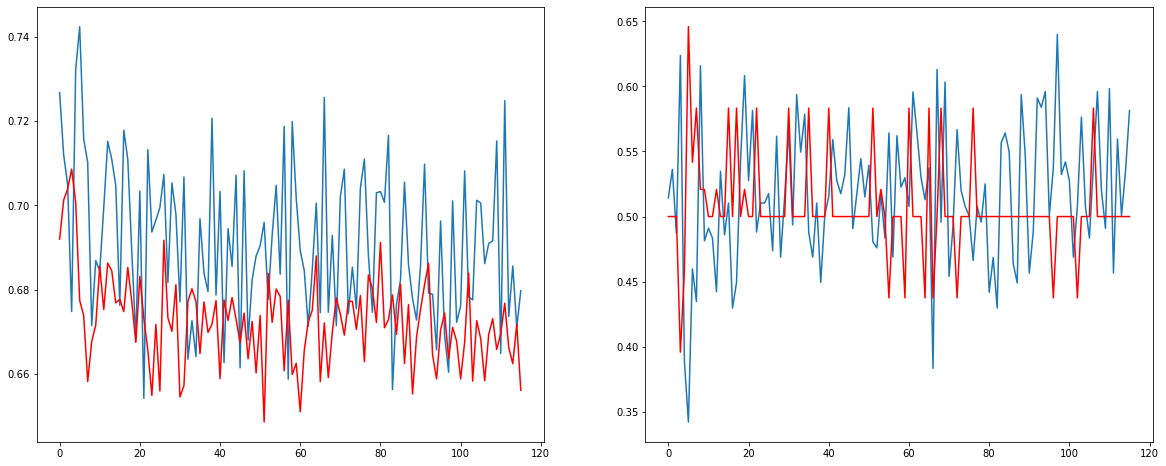

0
8
16
24
32
40
48
56


In [ ]:
bold_len = 128
maxIter = 500
BA_val = []
BA_train = []
loss_train = []
loss_val = []
no_train_samples = len(train_sub)
no_test_samples = len(test_sub)
batch_size = 4
# no_batches 

batch_size_test = 2
two_loss_fac = 0.5
# y_cond_train = torch.ones((batch_size,)).to(device)
# y_cond_test = torch.ones((batch_size_test,)).to(device)

for batch_idx in range(maxIter):
    perm_pos = torch.randperm(no_train_samples)
    train_y_perm = train_y[perm_pos]
    pred_val = np.array([])
    act_val = np.array([])
    loss_per_batch = []
    model.train()
    
    for j in range(0,no_train_samples,batch_size):
        if((j+batch_size)>no_train_samples):
            ed_pt = no_train_samples
        else:
            ed_pt = j+batch_size
            
        while(True):
            two_strt_pt = torch.randint(68,(2,))
            if(torch.abs(two_strt_pt[0]-two_strt_pt[1])>5):
                break
        data1 = torch.stack((all_data_train[perm_pos[j:ed_pt],two_strt_pt[0]:two_strt_pt[0]+bold_len,:],
                             all_data_train[perm_pos[j:ed_pt],two_strt_pt[1]:two_strt_pt[1]+bold_len,:]))
        data1 = F.normalize(data1)
        data1 = torch.unsqueeze(data1, dim=1)
        
        target = train_y_gpu[perm_pos[j:ed_pt]]

        optimizer.zero_grad()
        output = model(data1)
#         loss = loss_fn(output, target)        
        loss = two_loss_fac*loss_fn(output, target) + (1-two_loss_fac)*(smooth_l1_loss(output1[:],output2)) 
    
        y_pred = torch.argmax(output,dim = 1).cpu().numpy()
        pred_val = np.concatenate((pred_val,y_pred))
        act_val = np.concatenate((act_val,target.cpu().numpy()))

        loss.backward()
        optimizer.step()
        tr_los = loss.data
        tr_los = tr_los.cpu().numpy()
        loss_per_batch.append(tr_los)
        print(j)    
    loss_train.append(np.mean(loss_per_batch))
    BA_train.append(balanced_accuracy_score(act_val,pred_val))
    
    pred_val = np.array([])
#     act_val = np.array([])
    loss_per_batch = []
    model.eval()
#     for i in range(0,no_test_samples,batch_size_test):
    for i in range(0,no_test_samples,batch_size_test):
        if((i+batch_size_test)>no_test_samples):
            ed_pt = no_train_samples
        else:
            ed_pt = i+batch_size_test
            
        while(True):
            two_strt_pt = torch.randint(68,(2,))
            if(torch.abs(two_strt_pt[0]-two_strt_pt[1])>5):
                break        
        
        data1 = all_data_test[i:ed_pt,two_strt_pt[0]:two_strt_pt[0]+bold_len,:]
#         data2 = all_data_test[i:ed_pt,two_strt_pt[1]:two_strt_pt[1]+bold_len,:].to(device)
        data1 = F.normalize(data1)
        data1 = torch.unsqueeze(data1, dim=1)
        
        output = model(data1)
        loss = loss_fn(output, test_y_gpu[i:ed_pt])
    
        y_pred = torch.argmax(output,dim = 1).cpu().numpy()
        pred_val = np.concatenate((pred_val,y_pred))           
#         act_val = np.concatenate((act_val,test_y[i:ed_pt]))
        tr_los = loss.data
        tr_los = tr_los.cpu().numpy()
        loss_per_batch.append(tr_los)
    loss_val.append(np.mean(loss_per_batch))
    BA_val.append(balanced_accuracy_score(test_y,pred_val))

#     if(batch_idx%10 == 0):
    clear_output(wait=True)
    print('iteration:',batch_idx, '|-----|' 'train_loss:',loss_train[batch_idx],'|','train_BA:',BA_train[batch_idx],'|-----|',
         'val_loss:',loss_val[batch_idx],'|','val_BA:',BA_val[batch_idx],'|')
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    axs[0].plot(loss_train)
    axs[0].plot(loss_val,'r')
    axs[1].plot(BA_train)
    axs[1].plot(BA_val,'r')
    plt.show(fig)   


iteration: 498 |-----|train_loss: 0.38284373 | train_BA: 0.9045911047345767 |-----| val_loss: 0.7755128 | val_BA: 0.375 |


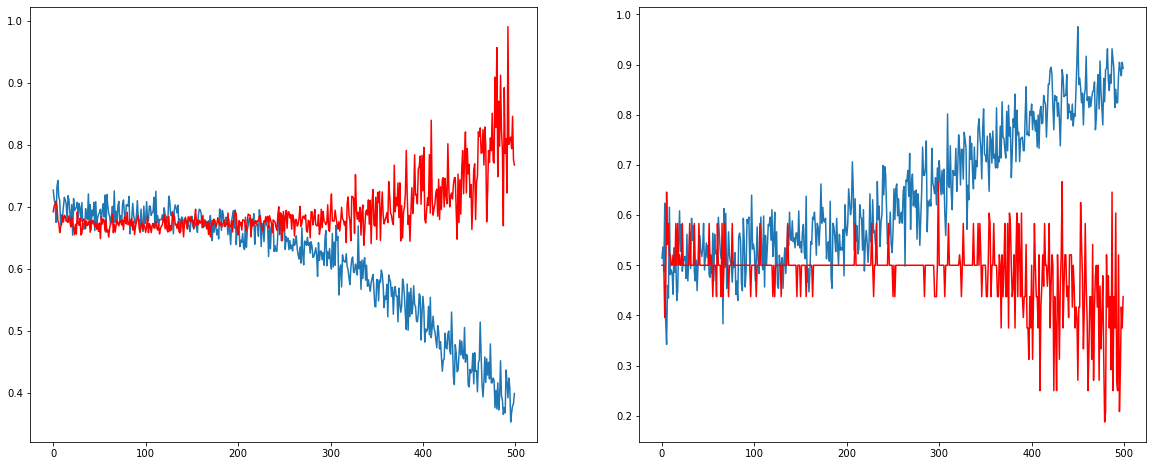

In [18]:
print('iteration:',batch_idx, '|-----|' 'train_loss:',loss_train[batch_idx],'|','train_BA:',BA_train[batch_idx],'|-----|',
     'val_loss:',loss_val[batch_idx],'|','val_BA:',BA_val[batch_idx],'|')
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(loss_train)
axs[0].plot(loss_val,'r')
axs[1].plot(BA_train)
axs[1].plot(BA_val,'r')
plt.show(fig)

In [ ]:
# bold_len = 128
# maxIter = 500
# BA_val = []
# BA_train = []
# loss_train = []
# loss_val = []
# no_train_samples = len(train_sub)
# batch_size = 5
# # no_batches 

# batch_size_test = len(test_y)
# two_loss_fac = 0.5
# y_cond_train = torch.ones((batch_size,)).to(device)
# y_cond_test = torch.ones((batch_size_test,)).to(device)

# for batch_idx in range(maxIter):
#     perm_pos = torch.randperm(no_train_samples)
#     train_y_perm = train_y[perm_pos]
#     pred_val = np.array([])
#     act_val = np.array([])
#     loss_per_batch = []
#     model.train()
    
#     for i in range(10):
#         while(True):
#             two_strt_pt = torch.randint(68,(2,))
#             if(torch.abs(two_strt_pt[0]-two_strt_pt[1])>5):
#                 break
#         for j in range(0,no_train_samples,batch_size):
#             if((j+batch_size)>no_train_samples):
#                 ed_pt = no_train_samples
#             else:
#                 ed_pt = j+batch_size
# #             data1 = all_data_train[perm_pos[j[0]:j[1]],two_strt_pt[0]:two_strt_pt[0]+bold_len,:]
# #             data2 = all_data_train[perm_pos[j[0]:j[1]],two_strt_pt[1]:two_strt_pt[1]+bold_len,:]
#             data1 = F.normalize(all_data_train[perm_pos[j:ed_pt],two_strt_pt[0]:two_strt_pt[0]+bold_len,:])
#             data2 = F.normalize(all_data_train[perm_pos[j:ed_pt],two_strt_pt[1]:two_strt_pt[1]+bold_len,:])
#             data1 = torch.unsqueeze(data1, dim=1)
#             data2 = torch.unsqueeze(data2, dim=1)
            
#             target = train_y_gpu[perm_pos[j:ed_pt]]
#             optimizer.zero_grad()
#             output, output1,output2 = model(data1,data2)
# #             loss = loss_fn(output, target) + la_diff_fac*(l2_penalty(output1,output2))        
#             loss = two_loss_fac*loss_fn(output, target) + (1-two_loss_fac)*(smooth_l1_loss(output1,output2))        


#             y_pred = torch.argmax(output,dim = 1).cpu().numpy()
# #             y_pred_prob = torch.sigmoid(output).detach()
# #             y_pred_prob = y_pred_prob.cpu().numpy()
# #             y_pred = np.ones(len(y_pred_prob))
# #             y_pred[y_pred_prob<0.5] = 0
#             pred_val = np.concatenate((pred_val,y_pred))
#             act_val = np.concatenate((act_val,target.cpu().numpy()))

#             loss.backward()
#             optimizer.step()
#             tr_los = loss.data
#             tr_los = tr_los.cpu().numpy()
#             loss_per_batch.append(tr_los)
#             print(j)
            
#     loss_train.append(np.mean(loss_per_batch))
#     BA_train.append(balanced_accuracy_score(act_val,pred_val))
    
#     pred_val = np.array([])
#     act_val = np.array([])
#     loss_per_batch = []
#     model.eval()
#     for i in range(5):
#         while(True):
#             two_strt_pt = torch.randint(68,(2,))
#             if(torch.abs(two_strt_pt[0]-two_strt_pt[1])>5):
#                 break        
# #         data1 = all_data_test[:,two_strt_pt[0]:two_strt_pt[0]+bold_len,:]
# #         data2 = all_data_test[:,two_strt_pt[1]:two_strt_pt[1]+bold_len,:]

#         data1 = F.normalize(all_data_test[:,two_strt_pt[0]:two_strt_pt[0]+bold_len,:]).to(device)
#         data2 = F.normalize(all_data_test[:,two_strt_pt[1]:two_strt_pt[1]+bold_len,:]).to(device)
#         data1 = torch.unsqueeze(data1, dim=1)
#         data2 = torch.unsqueeze(data2, dim=1)    
#         output, output1, output2 = model(data1,data2)
# #         loss = loss_fn(output, test_y_gpu) + la_diff_fac*(l2_penalty(output1,output2))
# #         loss = two_loss_fac*loss_fn(output, test_y_gpu) + (1-two_loss_fac)*(smooth_l1_loss(output1,output2,y_cond_test))
#         loss = two_loss_fac*loss_fn(output, test_y_gpu) + (1-two_loss_fac)*(smooth_l1_loss(output1,output2))
    
#         y_pred = torch.argmax(output,dim = 1).cpu().numpy()
# #         y_pred_prob = torch.sigmoid(output).detach()
# #         y_pred_prob = y_pred_prob.cpu().numpy()
# #         y_pred = np.ones(len(y_pred_prob))
# #         y_pred[y_pred_prob<0.5] = 0
#         pred_val = np.concatenate((pred_val,y_pred))           
#         act_val = np.concatenate((act_val,test_y))
#         tr_los = loss.data
#         tr_los = tr_los.cpu().numpy()
#         loss_per_batch.append(tr_los)
#     loss_val.append(np.mean(loss_per_batch))
#     BA_val.append(balanced_accuracy_score(act_val,pred_val))

# #     if(batch_idx%10 == 0):
#     clear_output(wait=True)
#     print('iteration:',batch_idx, '|-----|' 'train_loss:',loss_train[batch_idx],'|','train_BA:',BA_train[batch_idx],'|-----|',
#          'val_loss:',loss_val[batch_idx],'|','val_BA:',BA_val[batch_idx],'|')
#     fig, axs = plt.subplots(1, 2, figsize=(20, 8))
#     axs[0].plot(loss_train)
#     axs[0].plot(loss_val,'r')
#     axs[1].plot(BA_train)
#     axs[1].plot(BA_val,'r')
#     plt.show(fig)   
